In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/cantilever_25.csv", on_bad_lines='skip')
df = df.sample(frac=1) #shuffle


plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

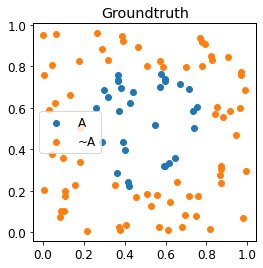

In [62]:
batch_size=64
nr_samples = 100
nr_samples_train = 50
data = np.random.uniform([0,0],[1,1],(nr_samples,2))
labels = np.sum(np.square(data - [.5,.5]),axis=1)<.09

# 400 examples for training; 100 examples for training
ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
        .batch(batch_size)
ds_test = tf.data.Dataset\
        .from_tensor_slices((data[nr_samples_train:],labels[nr_samples_train:]))\
        .batch(batch_size)

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
plt.title("Groundtruth")
plt.legend()
plt.show()

In [46]:
A = ltn.Predicate.MLP([2],hidden_layer_sizes=(16,16))


In [47]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")


In [48]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(data, labels):
    x_A = ltn.Variable("x_A",data[labels])
    x_not_A = ltn.Variable("x_not_A",data[tf.logical_not(labels)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [49]:
for _data, _labels in ds_test:
    print("Initial sat level %.5f"%axioms(_data, _labels))
    break

2022-04-07 17:27:04.251596: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-07 17:27:04.252207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initial sat level 0.49747


In [50]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(2000):
    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        mean_metrics.reset_states()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))
        print("Epoch %d: Sat Level %.3f"%(epoch, mean_metrics.result() ))
mean_metrics.reset_states()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

2022-04-07 17:27:18.135705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-07 17:27:18.521839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0: Sat Level 0.498
Epoch 100: Sat Level 0.491
Epoch 200: Sat Level 0.490
Epoch 300: Sat Level 0.539
Epoch 400: Sat Level 0.604
Epoch 500: Sat Level 0.733
Epoch 600: Sat Level 0.810
Epoch 700: Sat Level 0.836
Epoch 800: Sat Level 0.838
Epoch 900: Sat Level 0.829
Epoch 1000: Sat Level 0.818
Epoch 1100: Sat Level 0.810
Epoch 1200: Sat Level 0.803
Epoch 1300: Sat Level 0.798
Epoch 1400: Sat Level 0.794
Epoch 1500: Sat Level 0.790
Epoch 1600: Sat Level 0.787
Epoch 1700: Sat Level 0.784
Epoch 1800: Sat Level 0.782
Epoch 1900: Sat Level 0.781
Training finished at Epoch 1999 with Sat Level 0.780


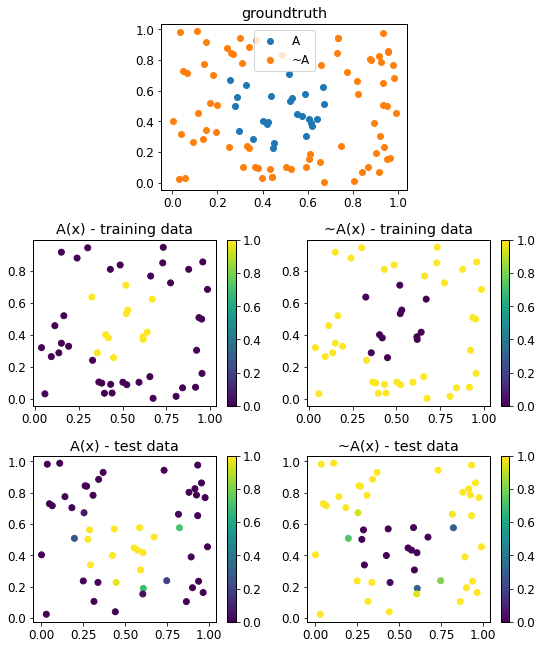

In [51]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()